# Solar Transformer

In [4]:
!pip install wandb scikit-learn tensorflow_probability tensorflow_addons matplotlib

In [5]:
from tensorflow.keras.layers import Add, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [1]:
ds = tf.data.Dataset.from_tensor_slices([ [1, 2], [3, 4], [np.nan, 5] ])
for i, x in enumerate(ds):
  print(i, ": ", x)

NameError: name 'tf' is not defined

## Plotting

In [ ]:
def plot_4d(matrix):
    fig = plt.figure(figsize=(10, 20), dpi=300)
    plt.title("Attention heatmap")

    # create grid
    x = np.arange(0, matrix.shape[0], 1, dtype=np.int32)  # timesteps
    y = np.arange(0, matrix.shape[1], 1, dtype=np.int32)    # patches
    z = np.arange(0, matrix.shape[2], 1, dtype=np.int32)  # timesteps
    X, Y, Z = np.meshgrid(x, y, z)

    X = X.transpose([1, 0, 2])
    Y = Y.transpose([1, 0, 2])
    Z = Z.transpose([1, 0, 2])

    for I in range(matrix.shape[3]):
        # Plot
        ax = plt.subplot(5, 5, I+1, projection="3d")
        ax.scatter3D(X, Y, Z, c=matrix[:, :, :, I], marker='s', s=99, cmap='magma')
        ax.set_title(
            f"{I}-th patch"
        )
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Patch")
        ax.set_zlabel("Timestep")

    plt.show()

## Masking

In [ ]:
# (Timestep, Patch)
def create_look_ahead_mask(size):
  n = tf.cast((size * (size+1) / 2), dtype=tf.int32)
  mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.bool), upper=False)
  mask = mask[:, tf.newaxis, :, tf.newaxis]  # (timestep, 1, timestep, 1)
  return mask

## Layer

In [ ]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        print(input_shape)
        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], input_shape[2], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        seq_len = tf.shape(inputs)[1]

        x = self.projection(inputs)
        x = x + self.position[:, :seq_len, :, :]

        return self.dropout(x, training=training)

In [ ]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        # MultiHeadAttention
        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),       # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training, attention_mask):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha(
            query=x,
            key=x,
            value=x,
            training=training,
            attention_mask=attention_mask,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y])

In [ ]:
class Decoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Decoder, self).__init__(**kwargs)

        # MultiHeadAttention
        self.mha_0 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )
        self.mha_1 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)
        self.dropout_2 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)
        self.norm_2 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()
        self.add_2 = Add()

    def call(self, inputs, enc_output, training, look_ahead_mask, attention_mask):
        # Attention block
        x = self.norm_0(inputs)
        x, block1 = self.mha_0(
            query=x,
            key=x,
            value=x,
            training=training,
            attention_mask=look_ahead_mask,
            return_attention_scores=True,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # Attention block
        y = self.norm_1(x)
        y, block2 = self.mha_1(
            query=y,
            key=enc_output,
            value=enc_output,
            training=training,
            attention_mask=attention_mask,
            return_attention_scores=True,
        )
        y = self.dropout_1(y, training=training)
        y = self.add_1([x, y])

        # MLP block
        z = self.norm_2(y)
        z = self.dense_0(z)
        z = self.dense_1(z)
        z = self.dropout_2(z, training=training)

        return self.add_2([y, z]), block1, block2

## Model

In [ ]:
class Transformer(Model):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_outputs,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm_enc = Normalization()
        self.input_norm_dec = Normalization()

        # Input
        self.pos_embs_0 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_1 = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.enc_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        self.norm_0 = LayerNormalization(epsilon=1e-5)

        # Decoder
        self.dec_layers = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        # Output
        self.final_layer = Dense(num_outputs, kernel_initializer=TruncatedNormal(stddev=0.02))

    def call(self, inputs, training):
        inputs, targets   = inputs
        attention_weights = {}

        missing_values_mask, look_ahead_mask = self.create_masks(inputs, targets)

        # Encoder input
        x_e = self.input_norm_enc(inputs)
        x_e = self.pos_embs_0(x_e, training=training)

        # Decoder input
        x_d = self.input_norm_dec(targets)
        x_d = self.pos_embs_1(x_d, training=training)

        # Encoder
        for layer in self.enc_layers:
            x_e = layer(x_e, training=training, attention_mask=missing_values_mask)
        x_e = self.norm_0(x_e)

        # Decoder
        for i, layer in enumerate(self.dec_layers):
            x_d, block1, block2 = layer(x_d, x_e, training=training, look_ahead_mask=look_ahead_mask, attention_mask=missing_values_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        x_d = self.norm_1(x_d)

        #plot_4d(attention_weights[f'decoder_layer{1}_block1'][0, 0, :, :, :, :])
        #plot_4d(attention_weights[f'decoder_layer{1}_block2'][0, 0, :, :, :, :])

        # Output
        final_output = self.final_layer(x_d)

        return final_output, attention_weights
    
    def train_step(self, inputs):
        inputs, targets = inputs
        inputs = inputs[:, :-1]
        targets_inputs = targets[:, :-1]
        targets_real = targets[:, 1:]
        mask = tf.cast(tf.math.greater_equal(targets_real, 0), dtype=tf.int32)

        with tf.GradientTape() as tape:
            y_pred, _ = self([inputs, targets_inputs], training=True)
            loss = self.compiled_loss(targets_real, y_pred, sample_weight=mask, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets_real, y_pred, sample_weight=mask)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, inputs):
        inputs, targets = inputs
        inputs = inputs[:, :-1]
        targets_inputs = targets[:, :-1]
        targets_real = targets[:, 1:]
        mask = tf.cast(tf.math.greater_equal(targets_real, 0), dtype=tf.int32)

        # Compute predictions
        y_pred, _ = self([inputs, targets_inputs], training=False)

        # Updates the metrics tracking the loss
        self.compiled_loss(targets_real, y_pred, sample_weight=mask, regularization_losses=self.losses)

        # Update the metrics.
        self.compiled_metrics.update_state(targets_real, y_pred, sample_weight=mask)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def create_masks(self, inputs, targets):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        missing_values_mask = create_missing_values_mask(inputs)

        # Used in the 1st attention block in the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
        dec_target_missing_values_mask = create_missing_values_mask(targets)
        look_ahead_mask = tf.logical_and(dec_target_missing_values_mask, look_ahead_mask)

        return missing_values_mask, look_ahead_mask

## Dataset

(14023, 25, 83) (14023, 25, 3) (336552, 25, 5)


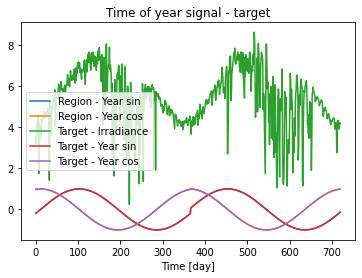

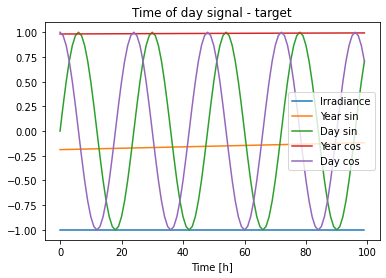

(11218, 25, 83) (1402, 25, 83)
(11218, 25, 3) (1402, 25, 3)
(269241, 25, 5) (33655, 25, 5)
Minimum: -1.0
Maximum: 9.020000457763672
Mean: 5.21748685836792
Standard deviation: 1.534839153289795

Minimum: -1.0
Maximum: 8.649999618530273
Mean: 1.7802436351776123
Standard deviation: 2.6906559467315674

Minimum: -1.0
Maximum: 1.0
Mean: -0.09971772879362106
Standard deviation: 0.7016564011573792

11204
11204
11204
<BatchDataset element_spec=(TensorSpec(shape=(None, 14, 25, 83), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14, 25, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 25, 5), dtype=tf.float32, name=None))>
350
1388
1388
1388
<BatchDataset element_spec=(TensorSpec(shape=(None, 14, 25, 83), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14, 25, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 25, 5), dtype=tf.float32, name=None))>
43


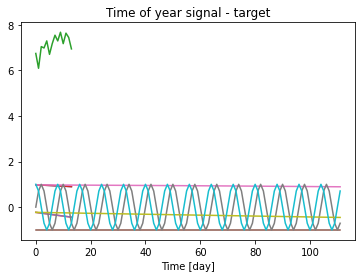

(<BatchDataset element_spec=(TensorSpec(shape=(None, 14, 25, 83), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14, 25, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 25, 5), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 14, 25, 83), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14, 25, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 25, 5), dtype=tf.float32, name=None))>,
 (array([[[ 4.14      ,  4.14      ,  3.99      , ...,  3.16      ,
           -0.18771857,  0.98222286],
          [ 4.48      ,  4.4       ,  4.4       , ...,  3.9       ,
           -0.18771857,  0.98222286],
          [ 3.72      ,  3.74      ,  3.74      , ...,  3.77      ,
           -0.18771857,  0.98222286],
          ...,
          [ 4.04      ,  4.04      ,  3.95      , ...,  2.91      ,
           -0.18771857,  0.98222286],
          [ 5.1       ,  4.84      ,  4.84      , ...,  3.52      ,
           -0.18771857,  0.9822

In [42]:
def load_dataset(window_size, batch_size):
    # load dataset
    f = np.load('./dataset/dataset-3.npz')
    X_all = f['X']
    y_daily_all = f['y_daily']
    y_hourly_all = f['y_hourly']
    print(X_all.shape, y_daily_all.shape, y_hourly_all.shape)

    plt.plot(X_all[:720, 0, -2])
    plt.plot(X_all[:720, 0, -1])
    plt.plot(y_daily_all[:720, 0, 0])
    plt.plot(y_daily_all[:720, 0, 1])
    plt.plot(y_daily_all[:720, 0, 2])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal - target')
    plt.legend(['Region - Year sin', 'Region - Year cos', 'Target - Irradiance', 'Target - Year sin', 'Target - Year cos'])
    plt.show()

    plt.plot(y_hourly_all[0:100, 0, 0])
    plt.plot(y_hourly_all[0:100, 0, 1])
    plt.plot(y_hourly_all[0:100, 0, 2])
    plt.plot(y_hourly_all[0:100, 0, 3])
    plt.plot(y_hourly_all[0:100, 0, 4])
    plt.xlabel('Time [h]')
    plt.title('Time of day signal - target')
    plt.legend(['Irradiance', 'Year sin', 'Day sin', 'Year cos', 'Day cos'])
    plt.show()

    # Split the data
    X_train = X_all[0:int(X_all.shape[0]*0.8)]
    X_val = X_all[int(X_all.shape[0]*0.8):int(X_all.shape[0]*0.9)]
    print(X_train.shape, X_val.shape)

    y_daily_train = y_daily_all[0:int(y_daily_all.shape[0]*0.8)]
    y_daily_val = y_daily_all[int(y_daily_all.shape[0]*0.8):int(y_daily_all.shape[0]*0.9)]
    print(y_daily_train.shape, y_daily_val.shape)

    y_hourly_train = y_hourly_all[0:int(y_hourly_all.shape[0]*0.8)]
    y_hourly_val = y_hourly_all[int(y_hourly_all.shape[0]*0.8):int(y_hourly_all.shape[0]*0.9)]
    print(y_hourly_train.shape, y_hourly_val.shape)

    # Descriptive Statistics
    print(f"Minimum: {np.min(X_train)}")
    print(f"Maximum: {np.max(X_train)}")
    print(f"Mean: {np.mean(X_train)}")
    print(f"Standard deviation: {np.std(X_train)}\n")

    # Descriptive Statistics
    print(f"Minimum: {np.min(y_daily_train)}")
    print(f"Maximum: {np.max(y_daily_train)}")
    print(f"Mean: {np.mean(y_daily_train)}")
    print(f"Standard deviation: {np.std(y_daily_train)}\n")

    # Descriptive Statistics
    print(f"Minimum: {np.min(y_hourly_train)}")
    print(f"Maximum: {np.max(y_hourly_train)}")
    print(f"Mean: {np.mean(y_hourly_train)}")
    print(f"Standard deviation: {np.std(y_hourly_train)}\n")

    dataset_1 = timeseries_dataset_from_array(
        data=X_train,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    for i, x in enumerate(dataset_1):
        pass
    print(i)
    dataset_2 = timeseries_dataset_from_array(
        data=y_daily_train,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    for i, x in enumerate(dataset_2):
        pass
    print(i)
    dataset_3 = timeseries_dataset_from_array(
        data=y_hourly_train,
        targets=None,
        sequence_length=(window_size * 8),
        sequence_stride=24,        # 1 day
        sampling_rate=3,
        shuffle=False,
        batch_size=None,
    )
    for i, x in enumerate(dataset_3):
        pass
    print(i)
    train_dataset = tf.data.Dataset.zip((dataset_1, dataset_2, dataset_3))
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    # Shuffle locally at each iteration
    train_dataset = train_dataset.shuffle(buffer_size=batch_size * 8)
    train_dataset = train_dataset.batch(batch_size)
    print(train_dataset)
    for i, x in enumerate(train_dataset):
        pass
    print(i)

    dataset_1 = timeseries_dataset_from_array(
        data=X_val,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    for i, x in enumerate(dataset_1):
        pass
    print(i)
    dataset_2 = timeseries_dataset_from_array(
        data=y_daily_val,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,        # 1 day
        shuffle=False,
        batch_size=None,
    )
    for i, x in enumerate(dataset_2):
        pass
    print(i)
    dataset_3 = timeseries_dataset_from_array(
        data=y_hourly_val,
        targets=None,
        sequence_length=(window_size * 8),
        sequence_stride=24,        # 1 day
        sampling_rate=3,
        shuffle=False,
        batch_size=None,
    )
    for i, x in enumerate(dataset_3):
        pass
    print(i)
    val_dataset = tf.data.Dataset.zip((dataset_1, dataset_2, dataset_3))
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    # Shuffle locally at each iteration
    val_dataset = val_dataset.shuffle(buffer_size=batch_size * 8)
    val_dataset = val_dataset.batch(batch_size)
    print(val_dataset)
    for i, x in enumerate(val_dataset):
        pass
    print(i)

    for x, y, z in train_dataset:
      plt.plot(x[0, :, 0, -2])
      plt.plot(x[0, :, 0, -1])

      plt.plot(y[0, :, 0, 0])
      plt.plot(y[0, :, 0, 1])
      plt.plot(y[0, :, 0, 2])

      plt.plot(z[0, :, 0, 0])
      plt.plot(z[0, :, 0, 1])
      plt.plot(z[0, :, 0, 2])
      plt.plot(z[0, :, 0, 3])
      plt.plot(z[0, :, 0, 4])
      plt.xlabel('Time [day]')
      plt.title('Time of year signal - target')
      break

    plt.show()

    return train_dataset, val_dataset, (X_train, y_daily_train, y_hourly_train)

load_dataset(window_size=14, batch_size=32)

## Simulator

In [ ]:
class Simulator(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, inputs, horizon_length):
    inputs, targets = inputs
    output_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    for i in tf.range(horizon_length):
      tar = targets[:, i:]
      print(tar[0])
      
      # Concatenate history with the predicted future
      if i > 0:
        output = tf.transpose(output_array.stack(), perm=[1, 0, 2, 3])
        tar = tf.concat([tar, output], axis=1)
        print(tar[0])

      predictions, _ = self.transformer([inputs, tar], training=False)

      # select the last prediction
      predictions = predictions[:, -1, :, :]  # (batch_size, patch, features)

      # concatentate the prediction to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i, predictions)

    output = tf.transpose(output_array.stack(), perm=[1, 0, 2, 3])
    print(output.shape)

    return output

In [ ]:
transformer = Transformer(
    num_encoder_layers=1, num_decoder_layers=1, embed_dim=128, num_heads=6, mlp_dim=256,
    num_outputs=1, dropout_rate=0.1, attention_dropout_rate=0.1
)
simulator = Simulator(transformer)

In [ ]:
horizon = 4
window_size = 21
batch_size = 64

# load dataset
_, _, test_dataset = load_dataset(window_size=(window_size + horizon - 1))

test_dataset = test_dataset.batch(batch_size)

In [ ]:
for inputs in test_dataset:
    inputs, targets = inputs
    inputs = inputs[:, :-horizon]
    targets_inputs = targets[:, :-horizon]

    y_pred, _ = transformer([inputs, targets_inputs], training=False)
    break

transformer.load_weights('./models/model-best.h5')

In [ ]:
mse_obj = MeanSquaredError()
rmse_obj = RootMeanSquaredError()
r_square = RSquare(y_shape=(horizon, 25, 1))
metrics = [mse_obj, rmse_obj, r_square]

for inputs in test_dataset:
    inputs, targets = inputs
    inputs = inputs[:, :-horizon]
    targets_inputs = targets[:, :-horizon]
    targets_real = targets[:, -horizon:]
    mask = tf.math.greater_equal(targets_real, 0)

    y_pred = simulator([inputs, targets_inputs], horizon)

    # get error of the last prediction
    for m in metrics:
        m.update_state(targets_real, y_pred, sample_weight=mask)

    break
# Return a dict mapping metric names to current value.
# Note that it will include the loss (tracked in self.metrics).
result = {m.name: m.result().numpy() for m in metrics}
print(result)
